In [ ]:
import pandas as pd
import numpy as np
import re

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read data

In [5]:
listingsN = pd.read_csv('data/03_linked/enriched_listing.csv')

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\1147631596.py:1: DtypeWarning: Columns (31,62) have mixed types. Specify dtype option on import or set low_memory=False.
  listingsN = pd.read_csv('data/03_linked/enriched_listing.csv')


# 2. Sample selection

In [7]:
# Drop park home
listingsN_h = listingsN[(listingsN['PROPERTY_TYPE']=='House') | (listingsN['PROPERTY_TYPE']=='Bungalow')  | (listingsN['PROPERTY_TYPE']=='Flat')  | (listingsN['PROPERTY_TYPE']=='Maisonette')]

In [8]:
# flat/maisonette share
listingsN[(listingsN['PROPERTY_TYPE']=='Flat') | (listingsN['PROPERTY_TYPE']=='Maisonette')].shape[0]/listingsN.shape[0]

0.13030189707151993

In [9]:
# remaining sample percentage
listingsN_h.shape[0], listingsN_h.shape[0]/listingsN.shape[0]

(216591, 0.9999722987853017)

# 3. Data reduction

In [ ]:
vars = ['listing_id','uprn','price','tenure','TOTAL_FLOOR_AREA','PROPERTY_TYPE','NUMBER_HABITABLE_ROOMS','bedrooms','bathrooms','BUILT_FORM','CONSTRUCTION_AGE_BAND',
       'new_home','FLOOR_LEVEL','CURRENT_ENERGY_RATING',
       'LAD21NM','date','lsoa11','msoa11','INSPECTION_DATE','TRANSACTION_TYPE',
       'summary_description','detailed_description','image_list','FLAT_TOP_STOREY',
       'X_COORDINATE','Y_COORDINATE','LATITUDE','LONGITUDE','Overall effectivenessprimary','Overall effectivenesssecondary','income_score','accessibility_PCA1','accessibility_PCA2',
       'population_2020','pop_den_2020','lsoa_area','CURRENT_ENERGY_EFFICIENCY']

In [14]:
listingsN_h_var = listingsN_h[vars].copy()

In [16]:
listingsN_h_var.shape

(216591, 37)

# 3. Feature extraction

## 3.1 Text

In [ ]:
# text preprocessing
listingsN_h_var['summary_description'].isna().sum(), listingsN_h_var['detailed_description'].isna().sum()

np.int64(23)

In [21]:
# replace null detailed description with summary description
listingsN_h_var['detailed_description'] = listingsN_h_var['detailed_description'].fillna(listingsN_h_var['summary_description'])

In [22]:
listingsN_h_var['detailed_description'].isna().sum()

np.int64(22)

In [23]:
listingsN_h_var['detailed_description'] = listingsN_h_var['detailed_description'].astype(str)
listingsN_h_var['summary_description'] = listingsN_h_var['summary_description'].astype(str)

### Modern kitchen

In [24]:
def is_modern_near_kitchen(text, max_distance=3):
    if not isinstance(text, str):  # Ensure input is a string
        return False
    
    # Regular expression to match "kitchen" and "modern" within max_distance words
    pattern = fr'\bkitchen\b(?:\W+\w+){{0,{max_distance}}}\W+\bmodern\b|\bmodern\b(?:\W+\w+){{0,{max_distance}}}\W+\bkitchen\b'
    
    # Search the text
    match = re.search(pattern, text, re.IGNORECASE)
    return match is not None

In [25]:
listingsN_h_var['modern_kitchen'] = listingsN_h_var['detailed_description'].apply(is_modern_near_kitchen)

In [26]:
listingsN_h_var['modern_kitchen'].value_counts()

modern_kitchen
False    166045
True      50546
Name: count, dtype: int64

### Garage

In [27]:
listingsN_h_var['is_garages'] = listingsN_h_var['detailed_description'].str.contains(
    r'\b(?:garage|garages)\b(?!d)', case=False, na=False
)

In [28]:
listingsN_h_var['is_garages'].value_counts()

is_garages
False    150239
True      66352
Name: count, dtype: int64

### Basement

In [29]:
listingsN_h_var['is_basements'] = listingsN_h_var['detailed_description'].str.contains(
    r'\b(?:basement|basements)\b(?!d)', case=False, na=False
)

In [30]:
listingsN_h_var['is_basements'].value_counts()

is_basements
False    213758
True       2833
Name: count, dtype: int64

### Garden

In [31]:
listingsN_h_var['is_gardens'] = listingsN_h_var['detailed_description'].str.contains(
    r'\b(?:garden|gardens)\b(?!d)', case=False, na=False
)

In [32]:
listingsN_h_var['is_gardens'].value_counts()

is_gardens
True     176981
False     39610
Name: count, dtype: int64

### Balcony/terrace/patio

In [33]:
listingsN_h_var['is_balconies'] = listingsN_h_var['detailed_description'].str.contains(
    r'\b(?:terrace|terraces|balcony|balconies|patio|patios)\b(?!d)', case=False, na=False
)

In [34]:
listingsN_h_var['is_balconies'].value_counts()

is_balconies
True     113374
False    103217
Name: count, dtype: int64

## 3.2 Images

In [35]:
# date to pd datetime
listingsN_h_var['date'] = pd.to_datetime(listingsN_h_var['date'],format='%Y-%m-%d')

In [36]:
# sort by date
listingsN_h_var = listingsN_h_var.sort_values(by='date')

In [38]:
# detail url for each image available from 2020-08-11
# for listing before 2020-08-11: link to old version Zoopla
image_date = '2020-08-11'

listing_image = listingsN_h_var[listingsN_h_var['date']>=image_date].copy()

In [39]:
# df for listings need to link to image list
listing_nimage = listingsN_h_var[listingsN_h_var['date']<image_date].copy()

In [41]:
listing_nimage['listing_id'].duplicated().value_counts()

listing_id
False    90593
Name: count, dtype: int64

# 4. Data cleaning

## 4.1 Consistency check

### 4.1.1 Data type check

In [49]:
# Data type handling
listingsN_h_var['uprn'] = listingsN_h_var['uprn'].astype('Int64').astype(str)

In [50]:
listingsN_h_var['listing_id'] = listingsN_h_var['listing_id'].astype(str)

In [51]:
listingsN_h_var['NUMBER_HABITABLE_ROOMS'] = listingsN_h_var['NUMBER_HABITABLE_ROOMS'].astype('Int64')

### 4.1.2 Numeric values check

In [52]:
listingsN_h_var.describe()

,price,TOTAL_FLOOR_AREA,NUMBER_HABITABLE_ROOMS,bedrooms,bathrooms,date,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,Overall effectivenessprimary,Overall effectivenesssecondary,income_score,accessibility_PCA1,accessibility_PCA2,population_2020,pop_den_2020,lsoa_area,CURRENT_ENERGY_EFFICIENCY
count,2.165910e+05,216591.000000,202204.0,216591.000000,216591.000000,216591,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000,216591.000000
mean,2.285248e+05,90.397541,4.6588,2.798921,1.198748,2021-02-16 15:14:39.842652416,379452.798445,401434.781664,53.509092,-2.311367,3.063022,2.705810,0.143746,-0.236674,-0.103931,1739.748526,4373.118236,0.861454,64.456981
min,5.250000e+02,0.000000,0.0,0.000000,0.000000,2017-09-01 00:00:00,351890.000000,382246.000000,53.336989,-2.727037,1.000000,1.000000,0.004000,-15.364315,-5.409631,1045.000000,62.453277,0.048300,1.000000
25%,1.350000e+05,68.000000,4.0,2.000000,1.000000,2019-05-10 00:00:00,372017.500000,395937.000000,53.459981,-2.423728,3.000000,2.000000,0.062000,-4.548656,-1.244608,1471.000000,2303.568694,0.292800,59.000000
50%,1.900000e+05,81.000000,5.0,3.000000,1.000000,2021-03-04 00:00:00,380207.000000,401638.000000,53.510858,-2.299891,3.000000,3.000000,0.118000,-1.417519,-0.180263,1623.000000,3805.254379,0.430400,66.000000
75%,2.700000e+05,101.000000,5.0,3.000000,1.000000,2022-11-17 00:00:00,388494.600000,407113.790000,53.559879,-2.174950,3.000000,3.000000,0.209000,2.670308,1.065569,1880.000000,5633.494082,0.747800,71.000000
max,8.995000e+06,4320.000000,97.0,35.000000,23.000000,2024-05-31 00:00:00,401943.000000,419346.000000,53.670575,-1.972152,4.000000,4.000000,0.545000,30.761041,6.065732,7229.000000,45942.028986,25.683200,114.000000
std,1.679178e+05,43.956759,1.499946,0.923968,0.736369,NaN,11024.603622,7610.381026,0.068261,0.166411,0.482989,0.671749,0.097209,6.525394,1.654411,444.790323,3421.633144,1.570639,11.169742


### 4.1.3 Categorical check

In [55]:
# 2. categorical var
for col in listingsN_h_var:
    if col in ['listing_id','uprn','summary_description','detailed_description','image_list','lsoa11','msoa11','INSPECTION_DATE']:
        continue
    elif listingsN_h_var[col].dtype=='object':
        print(listingsN_h_var[col].value_counts())

tenure
leasehold            109953
freehold             101845
feudal                  666
shared                   94
share_of_freehold         3
Name: count, dtype: int64
PROPERTY_TYPE
House         173929
Flat           27162
Bungalow       14439
Maisonette      1061
Name: count, dtype: int64
BUILT_FORM
Semi-Detached           80579
Mid-Terrace             63831
Detached                38911
End-Terrace             27221
Enclosed End-Terrace     2205
NO DATA!                 2161
Enclosed Mid-Terrace     1683
Name: count, dtype: int64
CONSTRUCTION_AGE_BAND
England and Wales: 1900-1929       41245
England and Wales: 1930-1949       37769
England and Wales: 1950-1966       29257
England and Wales: 1967-1975       19298
England and Wales: before 1900     17186
NO DATA!                           13405
England and Wales: 2003-2006       12827
England and Wales: 1996-2002       11384
England and Wales: 1983-1990        9217
England and Wales: 1976-1982        9037
England and Wales: 1991-

### 4.1.4 Consistency handling

#### Tenure


In [56]:
listingsN_h_var['tenure'] = listingsN_h_var['tenure'].apply(lambda x: 'shared' if x == 'share_of_freehold' else x)

#### Built form

In [57]:
listingsN_h_var['BUILT_FORM'] = listingsN_h_var['BUILT_FORM'].apply(lambda x: np.nan if x in ['NO DATA!'] else x)

# aggregate
listingsN_h_var['BUILT_FORM'] = listingsN_h_var['BUILT_FORM'].apply(lambda x: 'Terraced' if x in['Mid-Terrace','End-Terrace','Enclosed End-Terrace','Enclosed Mid-Terrace'] else x)

In [58]:
listingsN_h_var['BUILT_FORM'].value_counts()

BUILT_FORM
Terraced         94940
Semi-Detached    80579
Detached         38911
Name: count, dtype: int64

#### Age

In [59]:
# null data
listingsN_h_var['CONSTRUCTION_AGE_BAND'] = listingsN_h_var['CONSTRUCTION_AGE_BAND'].apply(lambda x: np.nan if x in ['NO DATA!','INVALID!','nan'] else x)

In [60]:
listingsN_h_var['CONSTRUCTION_AGE_BAND'] = listingsN_h_var['CONSTRUCTION_AGE_BAND'].astype(str)

In [62]:
# drop head text
listingsN_h_var['CONSTRUCTION_AGE_BAND'] = listingsN_h_var['CONSTRUCTION_AGE_BAND'].apply(lambda x: x[19:] if len(x)>18 else x)

In [63]:
listingsN_h_var.loc[listingsN_h_var.CONSTRUCTION_AGE_BAND == '2007 onwards', "CONSTRUCTION_AGE_BAND"] = '2007-2011'

In [64]:
# number to category
for i, j in listingsN_h_var.iterrows():
    if j['CONSTRUCTION_AGE_BAND'].isdigit():
        year = int(j['CONSTRUCTION_AGE_BAND'])
        if year >= 2012:
            listingsN_h_var.loc[i,'CONSTRUCTION_AGE_BAND'] = '2012 onwards'
        elif year <= 1949 and year >= 1930:
            listingsN_h_var.loc[i,'CONSTRUCTION_AGE_BAND'] = '1930-1949'
        elif year <= 1966 and year >= 1950:
            listingsN_h_var.loc[i,'CONSTRUCTION_AGE_BAND'] = '1950-1966'
        elif year <= 2006 and year >= 2003:
            listingsN_h_var.loc[i,'CONSTRUCTION_AGE_BAND'] = '2003-2006'
        elif year <= 2011 and year >= 2007:
            listingsN_h_var.loc[i,'CONSTRUCTION_AGE_BAND'] = '2007-2011'

In [65]:
listingsN_h_var['CONSTRUCTION_AGE_BAND'].value_counts()

CONSTRUCTION_AGE_BAND
1900-1929       41245
1930-1949       37769
1950-1966       29258
1967-1975       19298
before 1900     17186
nan             14455
2003-2006       12827
1996-2002       11384
1983-1990        9217
1976-1982        9037
1991-1995        7258
2007-2011        6786
2012 onwards      871
Name: count, dtype: int64

In [66]:
listingsN_h_var['CONSTRUCTION_AGE_BAND'] = listingsN_h_var['CONSTRUCTION_AGE_BAND'].apply(lambda x: np.nan if x == 'nan' else x)

#### Floor level

In [68]:
listingsN_h_var[(listingsN_h_var['PROPERTY_TYPE'] == 'House') | (listingsN_h_var['PROPERTY_TYPE'] == 'Bungalow')]['FLOOR_LEVEL'].isna().sum()

np.int64(52926)

In [70]:
# house/bungalow - not applicable
listingsN_h_var['FLOOR_LEVEL'] = listingsN_h_var.apply(lambda row: 'Not applicable' if row['PROPERTY_TYPE'] in ['House','Bungalow'] else row['FLOOR_LEVEL'],axis=1)

# null
listingsN_h_var['FLOOR_LEVEL'] = listingsN_h_var['FLOOR_LEVEL'].apply(lambda x: np.nan if x in ['NODATA!','NO DATA!'] else x)


In [71]:
# floor level numeric
listingsN_h_var['FLOOR_LEVEL_NUM'] = listingsN_h_var['FLOOR_LEVEL'].copy()

def clean_floor_level(value):
    if isinstance(value, str):
        value = value.strip().lower()  # Normalize case
        # Handle ordinals like '1st', '2nd', etc.
        if value == 'ground':
            value = 'ground floor'
        if value.endswith("st") or value.endswith("nd") or value.endswith("rd") or value.endswith("th"):
            value = value[:-2]
        # Handle numeric-like strings
        if value.replace(".", "").isdigit():  # Allow floats
            return float(value) if "." in value else int(value)
        # Handle special cases
        if value == '-1.0':
            value = '-1'
        if value == "20+":
            return 20
        if value == "21st or above":
            return 21
    return value  # Return unchanged for unknown values

# Apply the cleaning function
listingsN_h_var['FLOOR_LEVEL_NUM'] = listingsN_h_var['FLOOR_LEVEL_NUM'].apply(clean_floor_level)

In [73]:
# floor level category
listingsN_h_var['FLOOR_LEVEL_CATEGORY'] = listingsN_h_var['FLOOR_LEVEL'].copy()

for i, j in listingsN_h_var.iterrows():
    if j['FLOOR_LEVEL_CATEGORY'] in ['Not applicable',np.nan]:
        continue
    elif j['FLAT_TOP_STOREY'] == 'Y':
        listingsN_h_var.loc[i,'FLOOR_LEVEL_CATEGORY'] = 'top floor'
    elif j['FLOOR_LEVEL_CATEGORY'] == '-1':
        listingsN_h_var.loc[i,'FLOOR_LEVEL_CATEGORY'] = 'Basement'
    elif j['FLOOR_LEVEL_CATEGORY'] in ['00','ground floor','0.0','0']:
        listingsN_h_var.loc[i,'FLOOR_LEVEL_CATEGORY'] = 'Ground'
    elif j['FLOOR_LEVEL_CATEGORY'] not in ['Ground','top floor','Basement','mid floor',np.nan]:
        listingsN_h_var.loc[i,'FLOOR_LEVEL_CATEGORY'] = 'mid floor'

In [ ]:
# drop flat_top_story
listingsN_h_var = listingsN_h_var.drop(['FLAT_TOP_STOREY'],axis=1)

## 4.2 Outliers

In [77]:
listingsN_h_var_con = listingsN_h_var.copy()

In [78]:
# compute log price
listingsN_h_var_con['log_price'] = np.log10(listingsN_h_var_con['price'])

### 4.2.1 Exploration

In [80]:
# Visualise distribution
num_var = ['log_price','TOTAL_FLOOR_AREA','NUMBER_HABITABLE_ROOMS','Overall effectivenessprimary','Overall effectivenesssecondary','income_score',
           'accessibility_PCA1','accessibility_PCA2','pop_den_2020']

df_toplot = listingsN_h_var_con[num_var].copy()

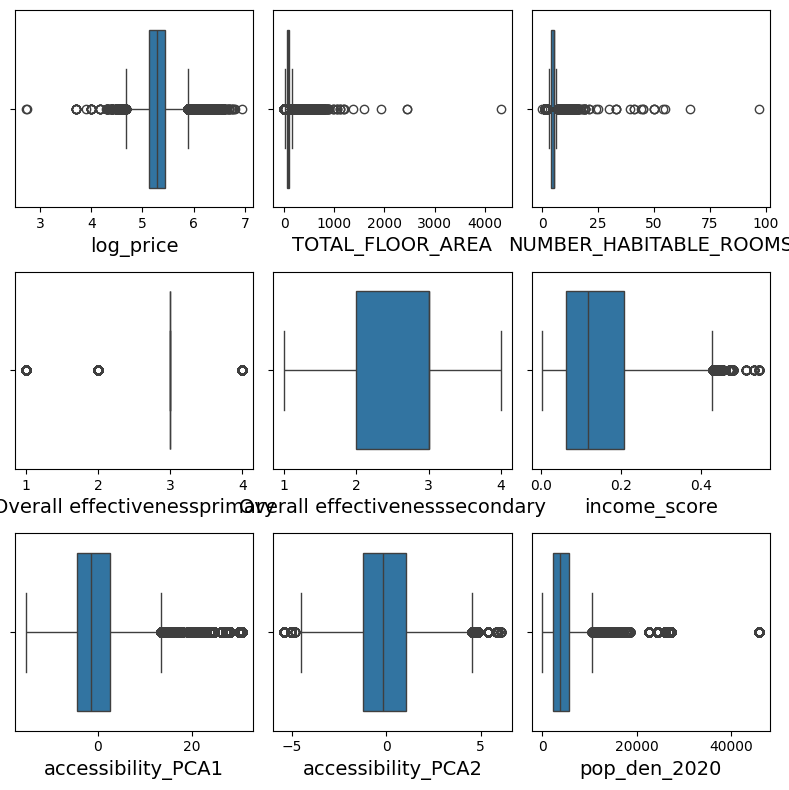

In [81]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8),dpi=100)

for axe, att in zip(axes.flatten(), df_toplot):
    sns.boxplot(ax=axe, data=df_toplot, x=att)
    axe.set_xlabel(att,fontsize=14)

fig.tight_layout()

<Axes: ylabel='NUMBER_HABITABLE_ROOMS'>

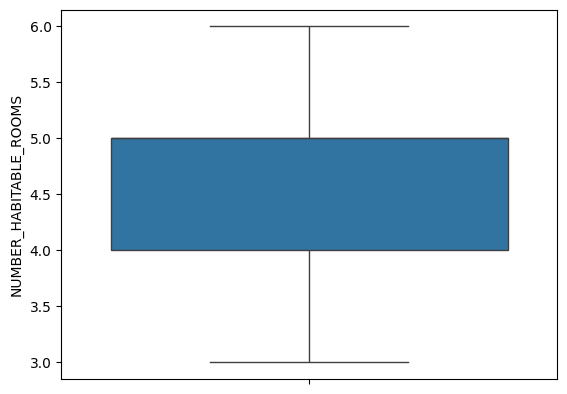

In [82]:
sns.boxplot(listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'], showfliers=False)

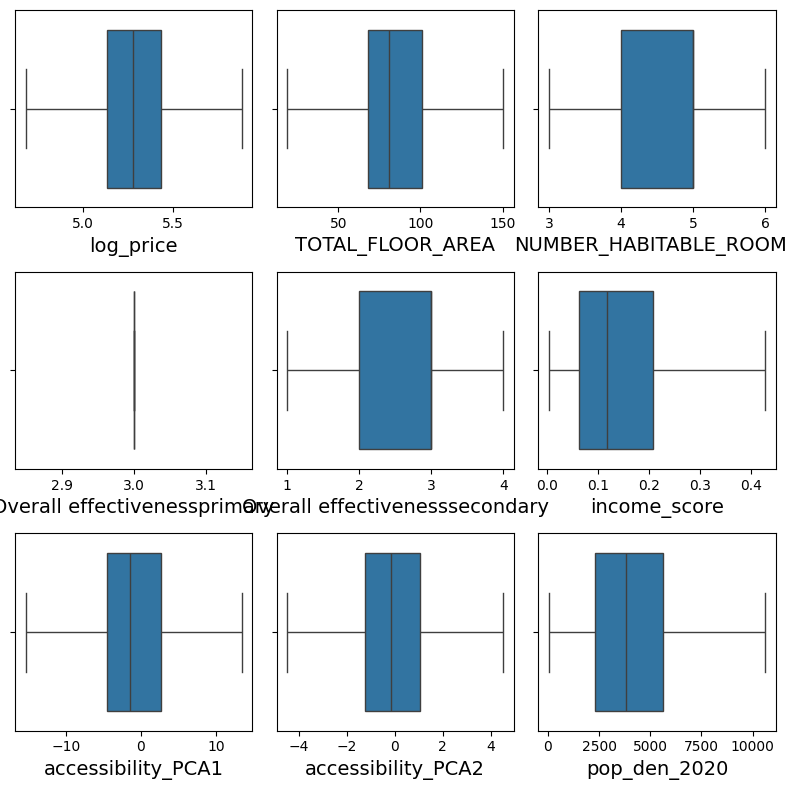

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8),dpi=100)

for axe, att in zip(axes.flatten(), df_toplot):
    sns.boxplot(ax=axe, data=df_toplot, x=att, showfliers=False)
    axe.set_xlabel(att,fontsize=14)

fig.tight_layout()

### 4.2.2 Trimming

In [196]:
# Price
listingsN_h_var_con[(listingsN_h_var_con['price'] < 30000) | (listingsN_h_var_con['price'] > 1500000)].shape, listingsN_h_var_con[(listingsN_h_var_con['price'] < 30000) | (listingsN_h_var_con['price'] > 1500000)].shape[0]/listingsN_h_var_con.shape[0]

((389, 44), 0.0017960118379803409)

In [197]:
# Floor area
listingsN_h_var_con[(listingsN_h_var_con['TOTAL_FLOOR_AREA'] < 20) | (listingsN_h_var_con['TOTAL_FLOOR_AREA'] > 200)].shape, listingsN_h_var_con[(listingsN_h_var_con['TOTAL_FLOOR_AREA'] < 20) | (listingsN_h_var_con['TOTAL_FLOOR_AREA'] > 200)].shape[0]/listingsN_h_var_con.shape[0]

((4783, 44), 0.022083096712236426)

In [198]:
# Habitable rooms
listingsN_h_var_con[(listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] > 10) | (listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] < 1)].shape, listingsN_h_var_con[(listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] > 10) | (listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] < 1)].shape[0]/listingsN_h_var_con.shape[0]

((15038, 44), 0.0694304010785305)

In [87]:
# replace missing rooms as 100
listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] = listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'].apply(lambda x: 100 if np.isnan(x) else x)

In [88]:
listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] = listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'].astype(int)

In [89]:
# Drop rows with outliers
# Set threshold conditions
condition = (listingsN_h_var_con['price'] >= 10000) & (listingsN_h_var_con['price'] <= 1500000) & (listingsN_h_var_con['TOTAL_FLOOR_AREA'] >= 20) & (listingsN_h_var_con['TOTAL_FLOOR_AREA'] <= 200) & (((listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] <= 10) & (listingsN_h_var_con['NUMBER_HABITABLE_ROOMS'] >= 1)) | (listingsN_h_var_con['NUMBER_HABITABLE_ROOMS']==100))

filtered_df_outliers = listingsN_h_var_con.loc[condition]

In [90]:
filtered_df_outliers.shape[0]/listingsN_h_var_con.shape[0]

0.9774690545775216

In [91]:
filtered_df_outliers.shape[0]

211711

In [92]:
# replace 100 with np.nan
filtered_df_outliers['NUMBER_HABITABLE_ROOMS'] = filtered_df_outliers['NUMBER_HABITABLE_ROOMS'].apply(lambda x: np.nan if x==100 else x)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2936712721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_outliers['NUMBER_HABITABLE_ROOMS'] = filtered_df_outliers['NUMBER_HABITABLE_ROOMS'].apply(lambda x: np.nan if x==100 else x)


In [93]:
filtered_df_outliers['NUMBER_HABITABLE_ROOMS'] = filtered_df_outliers['NUMBER_HABITABLE_ROOMS'].astype('Int64')

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\872719535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_outliers['NUMBER_HABITABLE_ROOMS'] = filtered_df_outliers['NUMBER_HABITABLE_ROOMS'].astype('Int64')


## 4.3 Missing data

### 4.3.1 Exploration

In [94]:
filtered_df_miss = filtered_df_outliers.copy()

In [95]:
filtered_df_miss.isna().sum()

listing_id                            0
uprn                                  0
price                                 0
tenure                             3817
TOTAL_FLOOR_AREA                      0
PROPERTY_TYPE                         0
NUMBER_HABITABLE_ROOMS            14027
bedrooms                              0
bathrooms                             0
BUILT_FORM                         2079
CONSTRUCTION_AGE_BAND             14092
new_home                              0
FLOOR_LEVEL                         149
CURRENT_ENERGY_RATING                 0
LAD21NM                               0
date                                  0
lsoa11                                0
msoa11                                0
INSPECTION_DATE                       0
TRANSACTION_TYPE                      0
summary_description                   0
detailed_description                  0
image_list                          207
X_COORDINATE                          0
Y_COORDINATE                          0


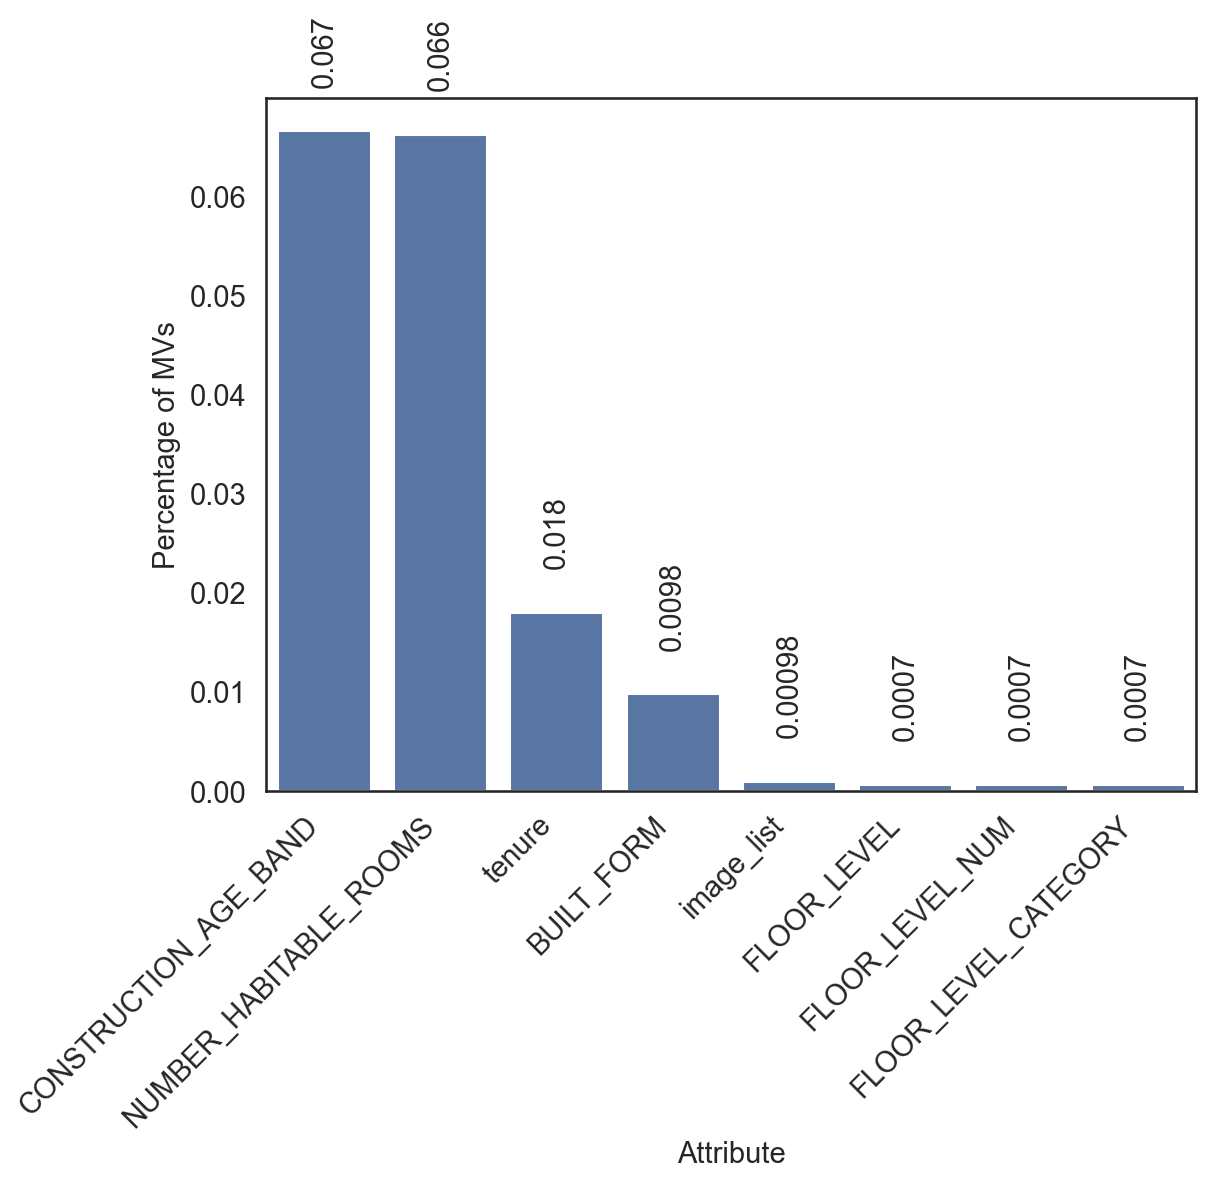

In [96]:
# 2. Distribution of MVs (barplot to visualize percentage of MVs)
mv_dict = pd.isna(filtered_df_miss).sum().to_dict()
df_miss = pd.DataFrame.from_dict(mv_dict,orient='index',columns=['misspercent'])
miss_analy = df_miss[df_miss.misspercent>0].sort_values(by='misspercent',ascending=False)
miss_analy['Attribute'] = miss_analy.index
miss_analy['misspercent'] = miss_analy['misspercent']/filtered_df_miss.shape[0]

fig = plt.figure(figsize=(8,6),dpi=150)
sns.set_theme(style="white")
sns.barplot(x="Attribute", y="misspercent", data=miss_analy,
             color="b")
plt.xticks(rotation=45,fontsize=14,ha='right')
plt.yticks(fontsize=14)
plt.ylabel('Percentage of MVs',fontsize=14)
plt.xlabel('Attribute',fontsize=14)
for x,y in enumerate(list(miss_analy.misspercent.values)):
    plt.text(x,y+0.005,'{:.2}'.format(y),ha='center',rotation=90,fontsize=14)
plt.show()

### 4.3.2 Compute some 'not missing at random' value

#### Age

In [97]:
filtered_df_miss['TRANSACTION_TYPE'] = filtered_df_miss['TRANSACTION_TYPE'].astype(str)

In [98]:
# missing percentage in new dwellings
filtered_df_miss[filtered_df_miss['TRANSACTION_TYPE'] == 'new dwelling']['CONSTRUCTION_AGE_BAND'].isna().sum()/filtered_df_miss['CONSTRUCTION_AGE_BAND'].isna().sum()

np.float64(0.9202384331535624)

In [99]:
# Use inspection date to infer the age of 'new dwelling'
filtered_df_miss['INSPECTION_DATE'] = pd.to_datetime(filtered_df_miss['INSPECTION_DATE'],format='%Y-%m-%d')

filtered_df_miss.loc[filtered_df_miss['TRANSACTION_TYPE'] == 'new dwelling', 'CONSTRUCTION_AGE_BAND'] = filtered_df_miss.loc[filtered_df_miss['TRANSACTION_TYPE'] == 'new dwelling', 'CONSTRUCTION_AGE_BAND'].fillna(filtered_df_miss['INSPECTION_DATE'].apply(lambda x: str(x)[:4]))

In [100]:
# tranform into age bands
filtered_df_miss['CONSTRUCTION_AGE_BAND'] = filtered_df_miss['CONSTRUCTION_AGE_BAND'].astype(str)

In [102]:
for i, j in filtered_df_miss.iterrows():
    if j['CONSTRUCTION_AGE_BAND'].isdigit():
        year = int(j['CONSTRUCTION_AGE_BAND'])
        if year >= 2012:
            filtered_df_miss.loc[i,'CONSTRUCTION_AGE_BAND'] = '2012 onwards'
        elif year <= 2011 and year >= 2007:
            filtered_df_miss.loc[i,'CONSTRUCTION_AGE_BAND'] = '2007-2011'

In [103]:
filtered_df_miss['CONSTRUCTION_AGE_BAND'] = filtered_df_miss['CONSTRUCTION_AGE_BAND'].apply(lambda x: np.nan if x == 'nan' else x)

In [104]:
filtered_df_miss['CONSTRUCTION_AGE_BAND'].value_counts()

CONSTRUCTION_AGE_BAND
1900-1929       40422
1930-1949       37192
1950-1966       28878
1967-1975       19007
before 1900     16143
2003-2006       12567
2012 onwards    12440
1996-2002       11066
1983-1990        9001
1976-1982        8824
2007-2011        7963
1991-1995        7084
Name: count, dtype: int64

In [105]:
filtered_df_miss['CONSTRUCTION_AGE_BAND'].isna().sum()

np.int64(1124)

#### Habitable rooms

To compute after outliers handling

In [106]:
# missing percentage in new dwellings
filtered_df_miss[filtered_df_miss['TRANSACTION_TYPE'] == 'new dwelling']['NUMBER_HABITABLE_ROOMS'].isna().sum()/filtered_df_miss['NUMBER_HABITABLE_ROOMS'].isna().sum()

np.float64(0.9601482854494903)

In [110]:
filtered_df_miss['bedrooms_off'] = filtered_df_miss['NUMBER_HABITABLE_ROOMS'] - filtered_df_miss['bedrooms']

In [111]:
filtered_df_miss[filtered_df_miss['TRANSACTION_TYPE'] == 'new dwelling']['bedrooms_off'].value_counts()

bedrooms_off
2    21
1    17
3     4
0     1
Name: count, dtype: Int64

In [113]:
filtered_df_miss['bedrooms_add2'] = listingsN_h_var_con['bedrooms'].apply(lambda x: x+2)

In [115]:
# Replace new dwelling habitable rooms with 'Not available'
filtered_df_miss['NUMBER_HABITABLE_ROOMS'] = filtered_df_miss.apply(lambda row: 'Not available' if row['TRANSACTION_TYPE'] == 'new dwelling' else row['NUMBER_HABITABLE_ROOMS'],axis=1)

## 4.4 Missing data further analysis

In [117]:
filtered_df_miss_comp = filtered_df_miss.copy()

In [118]:
filtered_df_miss_comp = filtered_df_miss_comp.drop(['bedrooms_off','bedrooms_add2'],axis=1)

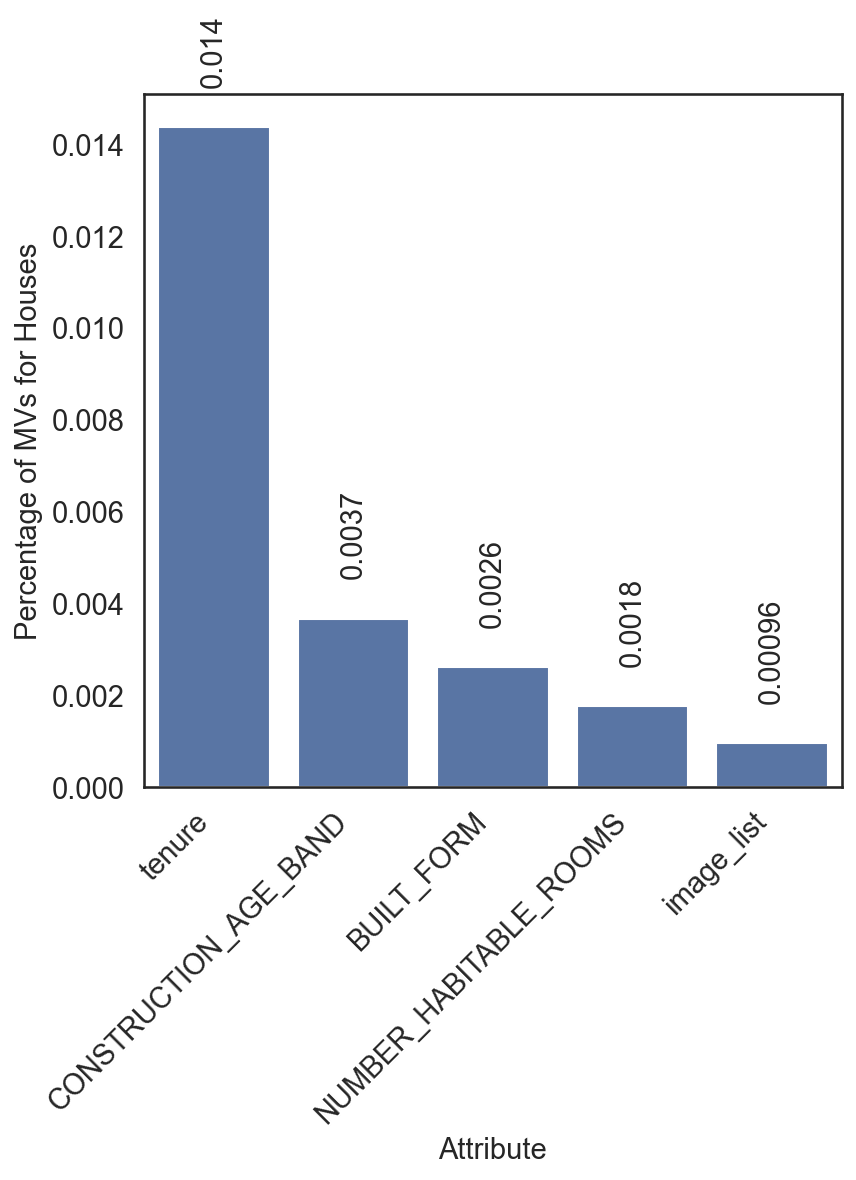

In [119]:
# 2. Distribution of MVs (barplot to visualize percentage of MVs)(hue by property type - house)
mv_dict = pd.isna(filtered_df_miss_comp[filtered_df_miss_comp['PROPERTY_TYPE']=='House']).sum().to_dict()
df_miss = pd.DataFrame.from_dict(mv_dict,orient='index',columns=['misspercent'])
miss_analy = df_miss[df_miss.misspercent>0].sort_values(by='misspercent',ascending=False)
miss_analy['Attribute'] = miss_analy.index
miss_analy['misspercent'] = miss_analy['misspercent']/filtered_df_miss_comp[filtered_df_miss_comp['PROPERTY_TYPE']=='House'].shape[0]

fig = plt.figure(figsize=(6,6),dpi=150)
sns.set_theme(style="white")
sns.barplot(x="Attribute", y="misspercent", data=miss_analy,
             color="b")
plt.xticks(rotation=45,fontsize=14,ha='right')
plt.yticks(fontsize=14)
plt.ylabel('Percentage of MVs for Houses',fontsize=14)
plt.xlabel('Attribute',fontsize=14)
for x,y in enumerate(list(miss_analy.misspercent.values)):
    plt.text(x,y+0.001,'{:.2}'.format(y),ha='center',rotation=90,fontsize=14)
plt.show()

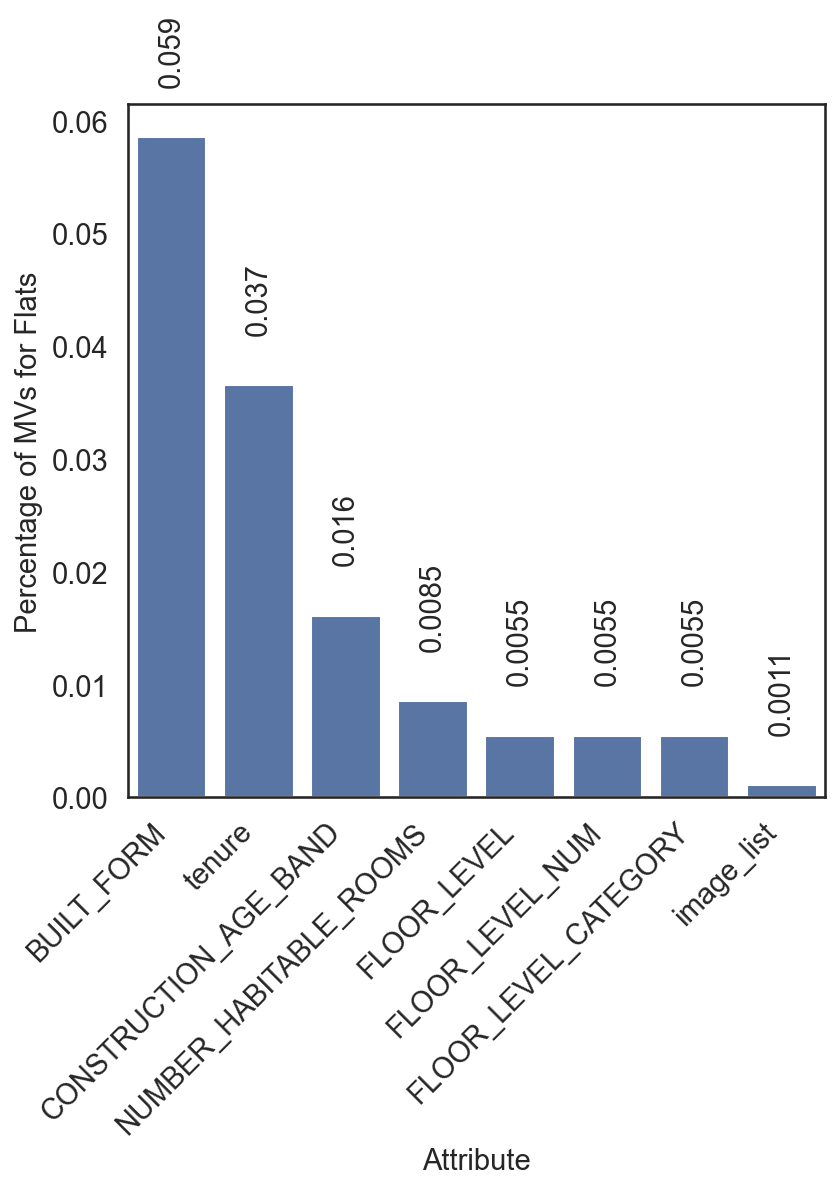

In [120]:
# 2. Distribution of MVs (barplot to visualize percentage of MVs)(hue by property type - flat)
mv_dict = pd.isna(filtered_df_miss_comp[filtered_df_miss_comp['PROPERTY_TYPE']=='Flat']).sum().to_dict()
df_miss = pd.DataFrame.from_dict(mv_dict,orient='index',columns=['misspercent'])
miss_analy = df_miss[df_miss.misspercent>0].sort_values(by='misspercent',ascending=False)
miss_analy['Attribute'] = miss_analy.index
miss_analy['misspercent'] = miss_analy['misspercent']/filtered_df_miss_comp[filtered_df_miss_comp['PROPERTY_TYPE']=='Flat'].shape[0]

fig = plt.figure(figsize=(6,6),dpi=150)
sns.set_theme(style="white")
sns.barplot(x="Attribute", y="misspercent", data=miss_analy,
             color="b")
plt.xticks(rotation=45,fontsize=14,ha='right')
plt.yticks(fontsize=14)
plt.ylabel('Percentage of MVs for Flats',fontsize=14)
plt.xlabel('Attribute',fontsize=14)
for x,y in enumerate(list(miss_analy.misspercent.values)):
    plt.text(x,y+0.005,'{:.2}'.format(y),ha='center',rotation=90,fontsize=14)
plt.show()

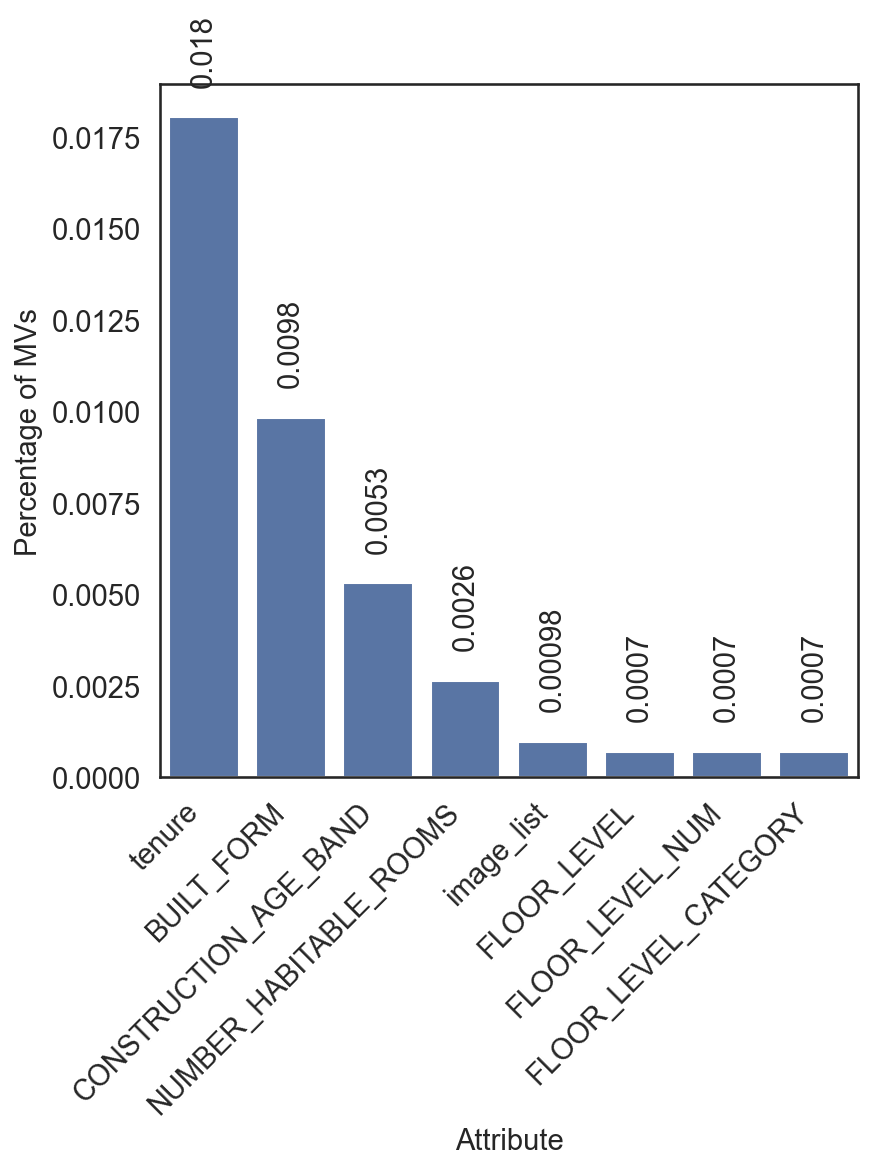

In [121]:
# 2. Distribution of MVs (barplot to visualize percentage of MVs)
mv_dict = pd.isna(filtered_df_miss_comp).sum().to_dict()
df_miss = pd.DataFrame.from_dict(mv_dict,orient='index',columns=['misspercent'])
miss_analy = df_miss[df_miss.misspercent>0].sort_values(by='misspercent',ascending=False)
miss_analy['Attribute'] = miss_analy.index
miss_analy['misspercent'] = miss_analy['misspercent']/filtered_df_miss_comp.shape[0]

fig = plt.figure(figsize=(6,6),dpi=150)
sns.set_theme(style="white")
sns.barplot(x="Attribute", y="misspercent", data=miss_analy,
             color="b")
plt.xticks(rotation=45,fontsize=14,ha='right')
plt.yticks(fontsize=14)
plt.ylabel('Percentage of MVs',fontsize=14)
plt.xlabel('Attribute',fontsize=14)
for x,y in enumerate(list(miss_analy.misspercent.values)):
    plt.text(x,y+0.001,'{:.2}'.format(y),ha='center',rotation=90,fontsize=14)
plt.show()

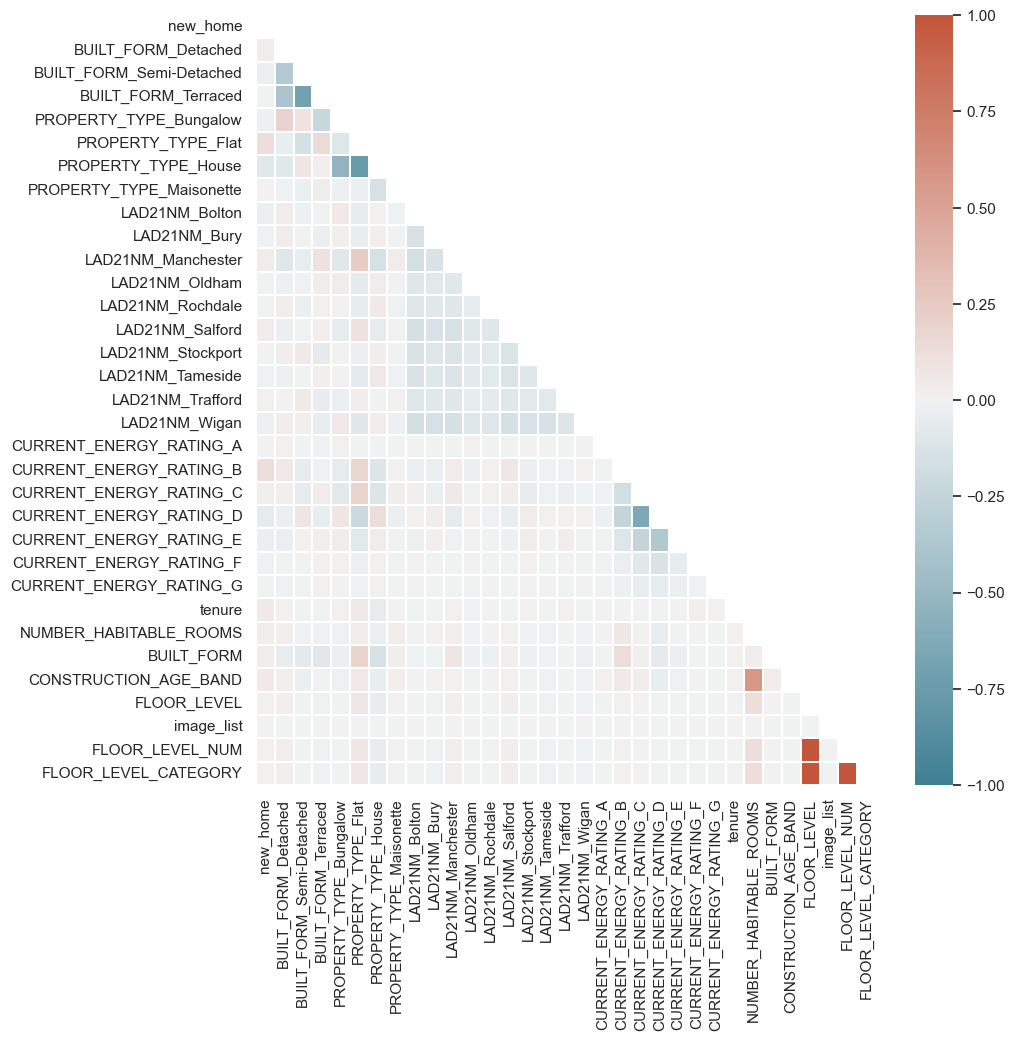

In [122]:
# Explore if there is bias in missing data
# 1. Find the correlation between missing value and 'property_type'
miss_att = filtered_df_miss_comp.columns[filtered_df_miss_comp.isna().any()].tolist()

fig = plt.figure(figsize=(10,10),dpi=100)
plt.rcParams['axes.labelsize'] = 1
plt.rcParams['axes.titlesize'] = 1

property_dummy = pd.get_dummies(filtered_df_miss_comp[['BUILT_FORM','PROPERTY_TYPE','LAD21NM','new_home','CURRENT_ENERGY_RATING']])
pla = sns.diverging_palette(220, 20, as_cmap=True)

ismiss = filtered_df_miss_comp[miss_att].isnull()
df_temp = pd.concat([property_dummy,ismiss],axis=1)
corr_matrix = df_temp.corr(method ='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(data=corr_matrix, mask=mask,cmap=pla,linewidths=0.1, linecolor='white',xticklabels=True, yticklabels=True,vmax=1.0, vmin=-1.0)

plt.show()

In [123]:
# Drop rows with missing data
filtered_complete_df = filtered_df_miss_comp.dropna()

In [124]:
filtered_complete_df.shape[0],filtered_complete_df.shape[0]/filtered_df_outliers.shape[0]

(204469, 0.965792991389205)

# 5. Data transformation

## 5.1 Exploration

### 5.1.1 Statistical

In [127]:
# Compute year and quarter
filtered_complete_df['date'] = pd.to_datetime(filtered_complete_df['date'])

filtered_complete_df['year'] = filtered_complete_df['date'].dt.year
filtered_complete_df['quarter'] = filtered_complete_df['date'].dt.quarter

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2307157717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['date'] = pd.to_datetime(filtered_complete_df['date'])
C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2307157717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['year'] = filtered_complete_df['date'].dt.year
C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2307157717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [128]:
filtered_complete_df[['NUMBER_HABITABLE_ROOMS']] = filtered_complete_df[['NUMBER_HABITABLE_ROOMS']].astype(str)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2188004735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df[['NUMBER_HABITABLE_ROOMS']] = filtered_complete_df[['NUMBER_HABITABLE_ROOMS']].astype(str)


C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\269955322.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe.set_xticklabels(xlabels,rotation=45, ha='right')
C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\269955322.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe.set_xticklabels(xlabels,rotation=45, ha='right')


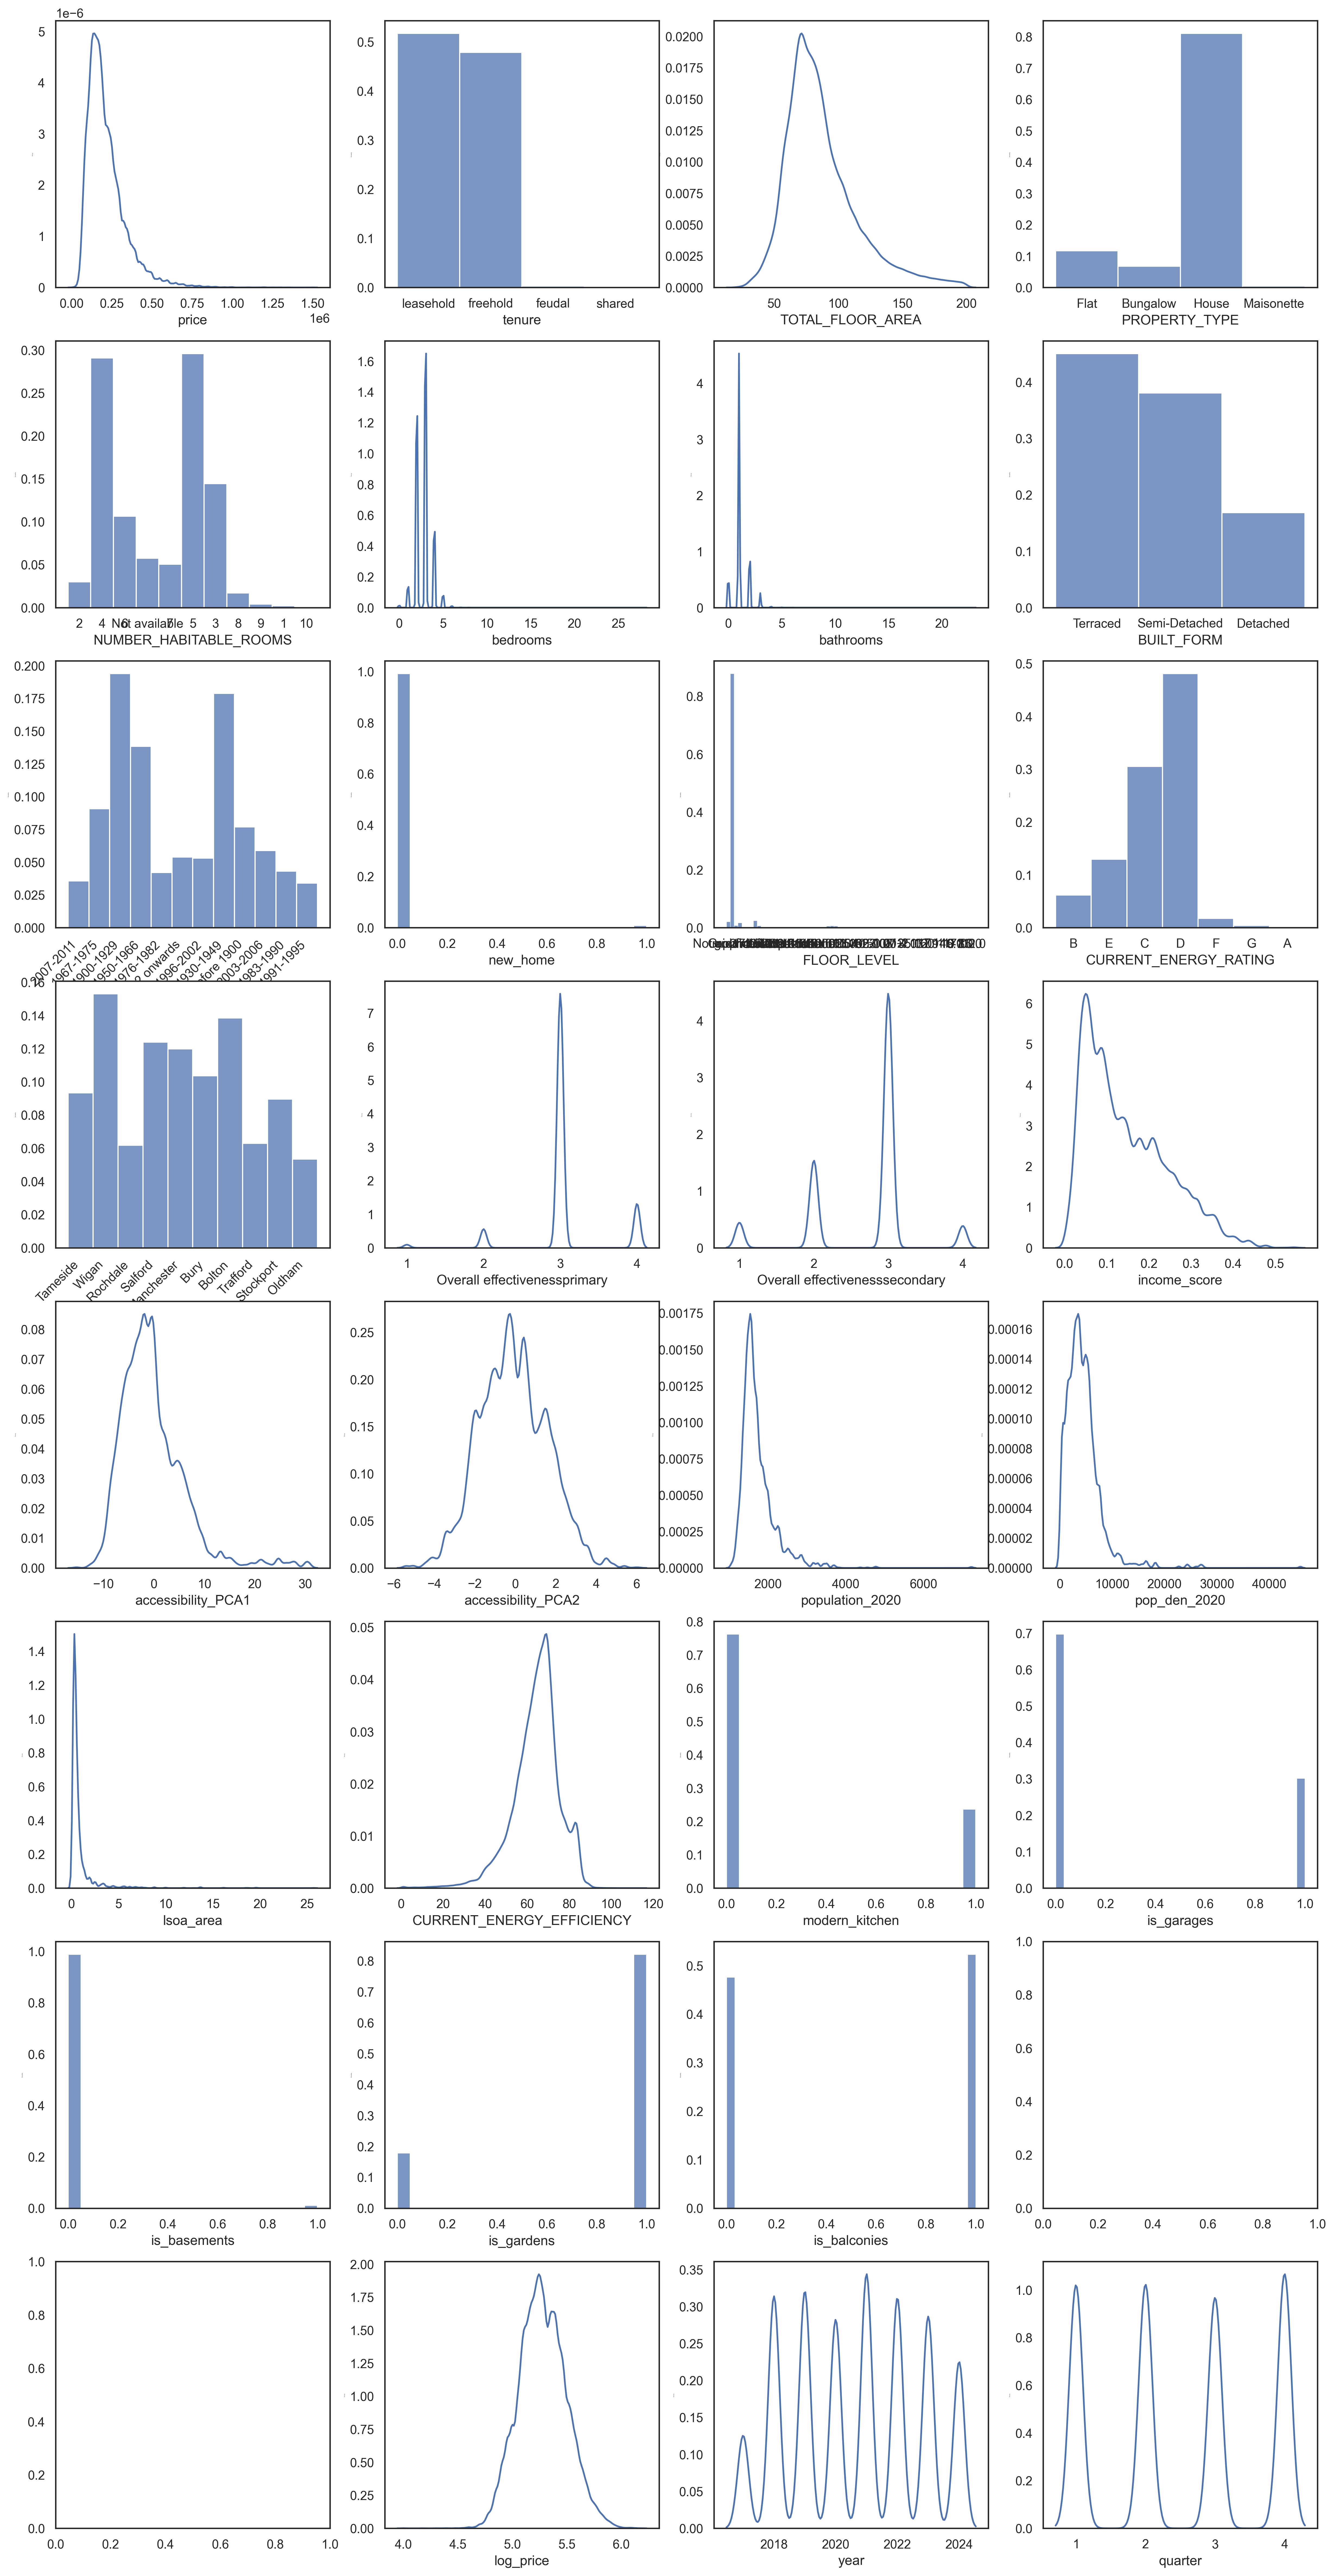

In [130]:
# Histogram
fig, axes = plt.subplots(8, 4, figsize=(20, 40),dpi=300)

df_temp = filtered_complete_df.copy()

df_temp = df_temp.drop(['listing_id','uprn','date','lsoa11','msoa11','INSPECTION_DATE','TRANSACTION_TYPE','summary_description','detailed_description','image_list','LATITUDE','LONGITUDE','X_COORDINATE',
       'Y_COORDINATE'],axis=1)

for axe, att in zip(axes.flatten(), df_temp):
    if att in ['FLOOR_LEVEL_NUM','FLOOR_LEVEL_CATEGORY']:
        continue
    elif (df_temp[att].dtypes == 'O') or (df_temp[att].dtypes == 'bool'):
        sns.histplot(ax=axe, data=df_temp, x=att,stat='probability')
        if att in ['LAD21NM','CONSTRUCTION_AGE_BAND','year']:
            xlabels = df_temp[att].unique()
            axe.set_xticklabels(xlabels,rotation=45, ha='right')
    else:
        if att in ['NUMBER_HABITABLE_ROOMS']:
            sns.histplot(ax=axe,data=df_temp, x=att,stat='probability')
        else:
            sns.kdeplot(ax=axe, data=df_temp, x=att)

    axe.set_xlabel(att, fontsize=12)

## 5.2 Transformation

### 5.2.0 Tenure

In [152]:
filtered_complete_df['tenure'].value_counts()

tenure
leasehold    105804
freehold      97947
feudal          622
shared           96
Name: count, dtype: int64

In [153]:
# group feudal, shared and leasehold
filtered_complete_df['tenure_mapped'] = filtered_complete_df['tenure'].apply(lambda x: 'leasehold' if x in ['feudal','shared'] else x)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\72707636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['tenure_mapped'] = filtered_complete_df['tenure'].apply(lambda x: 'leasehold' if x in ['feudal','shared'] else x)


In [154]:
filtered_complete_df['tenure_mapped'].value_counts()

tenure_mapped
leasehold    106522
freehold      97947
Name: count, dtype: int64

### 5.2.1 Property size

In [155]:
# log transform
filtered_complete_df['log_size'] = np.log(filtered_complete_df['TOTAL_FLOOR_AREA'])

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2562821802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['log_size'] = np.log(filtered_complete_df['TOTAL_FLOOR_AREA'])


### 5.2.2 Habitable rooms

In [156]:
filtered_complete_df['NUMBER_HABITABLE_ROOMS'].value_counts()

NUMBER_HABITABLE_ROOMS
5                60535
4                59461
3                29540
6                21791
Not available    11749
7                10339
2                 6142
8                 3497
9                  811
1                  449
10                 155
Name: count, dtype: int64

In [157]:
# Regrouping
room_mapping = {'1':'1-2','2':'1-2','3':'3','4':'4','5':'5','6':'6-7','7':'6-7','8':'8-10','9':'8-10','10':'8-10','Not available':'Not available'}
filtered_complete_df['rooms_mapped']  = filtered_complete_df['NUMBER_HABITABLE_ROOMS'].map(room_mapping)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\1362410341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['rooms_mapped']  = filtered_complete_df['NUMBER_HABITABLE_ROOMS'].map(room_mapping)


In [158]:
filtered_complete_df['rooms_mapped'].value_counts()

rooms_mapped
5                60535
4                59461
6-7              32130
3                29540
Not available    11749
1-2               6591
8-10              4463
Name: count, dtype: int64

### 5.2.3 Age band

In [159]:
filtered_complete_df['CONSTRUCTION_AGE_BAND'].value_counts()

CONSTRUCTION_AGE_BAND
1900-1929       39650
1930-1949       36550
1950-1966       28311
1967-1975       18570
before 1900     15750
2003-2006       12059
2012 onwards    11036
1996-2002       10854
1983-1990        8816
1976-1982        8613
2007-2011        7285
1991-1995        6975
Name: count, dtype: int64

In [160]:
# Regrouping
age_mapping = {'before 1900':'before 1900','1900-1929':'1900-1929','1930-1949':'1930-1949',
               '1950-1966':'1950-1966',
               '1967-1975':'1967-1982','1976-1982':'1967-1982',
               '1983-1990':'1983-2002','1991-1995':'1983-2002','1996-2002':'1983-2002',
               '2003-2006':'2003-2011','2007-2011':'2003-2011',
               '2012 onwards': '2012-2024'
               }

In [161]:
filtered_complete_df['age_mapped']  = filtered_complete_df['CONSTRUCTION_AGE_BAND'].map(age_mapping)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\1403538884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['age_mapped']  = filtered_complete_df['CONSTRUCTION_AGE_BAND'].map(age_mapping)


### 5.2.4 EPC band

In [163]:
epc_mapping = {'A':'AB','B':'AB','C':'C','D':'D','E':'E','F':'FG','G':'FG'} 
filtered_complete_df['epc_mapped']  = filtered_complete_df['CURRENT_ENERGY_RATING'].map(epc_mapping)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2611279393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['epc_mapped']  = filtered_complete_df['CURRENT_ENERGY_RATING'].map(epc_mapping)


In [164]:
filtered_complete_df['epc_mapped'].value_counts()

epc_mapped
D     98378
C     62437
E     26526
AB    12697
FG     4431
Name: count, dtype: int64

In [165]:
result = pd.crosstab(filtered_complete_df['lsoa11'], filtered_complete_df['epc_mapped'])
result.head()

epc_mapped,AB,C,D,E,FG
lsoa11,,,,,
E01004766,7,52,112,43,12
E01004767,16,68,150,22,7
E01004768,0,52,107,14,3
E01004769,3,95,130,24,5
E01004770,1,41,104,25,5


In [167]:
result.to_csv('data/04_processed/EPC_by_lsoa.csv')

### 5.2.5 Accessibility level

c:\Users\2702471O\OneDrive - University of Glasgow\03Price modelling\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: ylabel='accessibility_PCA1'>

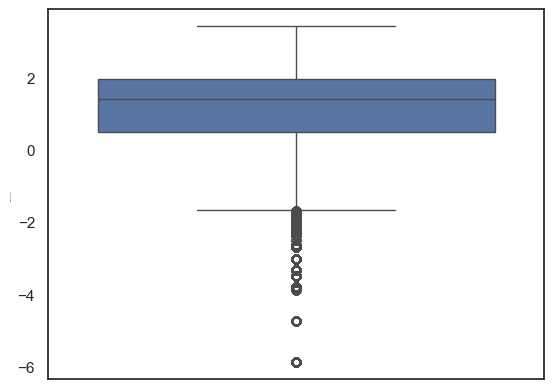

In [168]:
sns.boxplot(np.log(filtered_complete_df['accessibility_PCA1']))

<Axes: ylabel='accessibility_PCA2'>

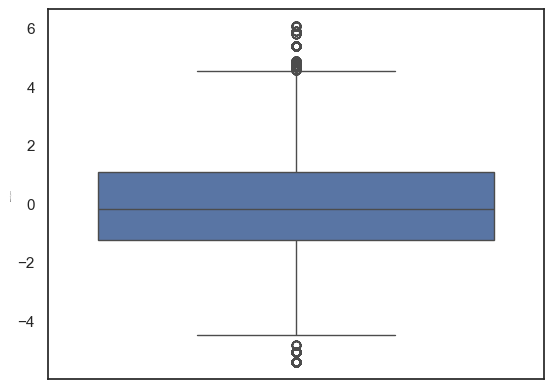

In [169]:
sns.boxplot(filtered_complete_df['accessibility_PCA2'])

### 5.2.6 IMD

<Axes: ylabel='income_score'>

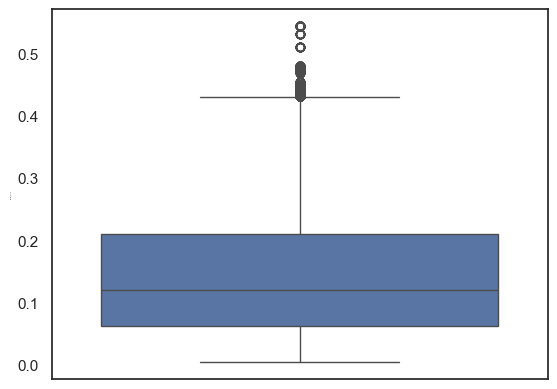

In [172]:
# use only income IMD score
sns.boxplot(filtered_complete_df['income_score'])

### 5.2.7 Transaction time

In [175]:
# Combine year and quarter
filtered_complete_df['year_quarter'] = filtered_complete_df['year'].astype(str) + '-Q' + filtered_complete_df['quarter'].astype(str)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\4066168319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['year_quarter'] = filtered_complete_df['year'].astype(str) + '-Q' + filtered_complete_df['quarter'].astype(str)


### 5.2.8 Population density

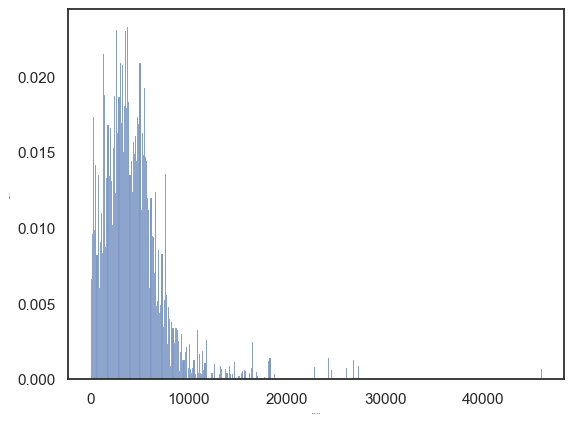

In [177]:
sns.histplot(data=filtered_complete_df, x='pop_den_2020',stat='probability')
plt.show()

In [179]:
# Log transform
filtered_complete_df['log_popden'] = np.log(filtered_complete_df['pop_den_2020'])

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\3094799055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['log_popden'] = np.log(filtered_complete_df['pop_den_2020'])


In [181]:
# Log transform (100 habitant/km2)
filtered_complete_df['log_popden_100'] = np.log(filtered_complete_df['pop_den_2020']/100)

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\2752786735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['log_popden_100'] = np.log(filtered_complete_df['pop_den_2020']/100)


<Axes: xlabel='log_popden_100'>

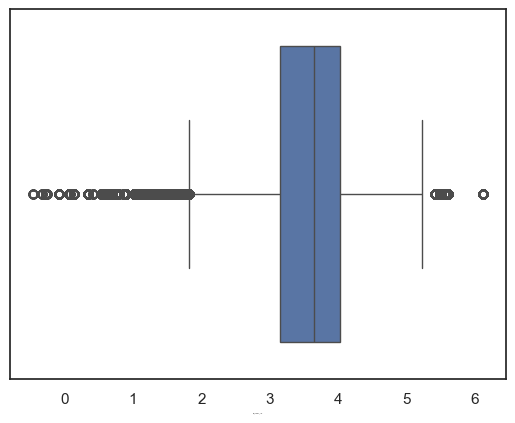

In [182]:
sns.boxplot(data=filtered_complete_df, x='log_popden_100')

### 5.2.9 Property type

In [185]:
# combine house/bungalow, flat/maisonette
filtered_complete_df['property_type_mapped'] = filtered_complete_df['PROPERTY_TYPE'].apply(lambda x: 'House' if x in ['House','Bungalow'] else 'Flat')

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\41989980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['property_type_mapped'] = filtered_complete_df['PROPERTY_TYPE'].apply(lambda x: 'House' if x in ['House','Bungalow'] else 'Flat')


### 5.2.10 School quality

In [188]:
# average deprivation score for primary and secondary school
filtered_complete_df['school_quality'] = (filtered_complete_df['Overall effectivenessprimary'] + filtered_complete_df['Overall effectivenesssecondary'])/2

C:\Users\2702471O\AppData\Local\Temp\ipykernel_433784\256769746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_complete_df['school_quality'] = (filtered_complete_df['Overall effectivenessprimary'] + filtered_complete_df['Overall effectivenesssecondary'])/2


# 6. Save data for modelling

In [189]:
filtered_complete_df.shape

(204469, 56)

In [193]:
filtered_complete_df.to_csv("data/04_processed/listing_processed.csv", chunksize=10000)